# Preparação Dos Dados


In [3]:
import pandas as pd
import numpy as np
import os

# Leitura dos dados originais
# Mostrar todas as colunas
pd.set_option('display.max_columns', None)
file_path = 'data/TUCURUI_DIARIA_1939_2016.xlsx'
data = pd.read_excel(file_path, header=None, names=['Vazao'])

# Função para calcular derivadas percentuais


def calcular_derivadas(data):
    data['V1'] = data['Vazao'].pct_change() * 100  # Primeira derivada
    data['V2'] = data['V1'].diff()  # Segunda derivada
    return data

# Função para criar defasagens


def criar_defasagens(data, colunas, entradas):
    defasagens_list = []

    for col in colunas:
        for i in range(entradas, 0, -1):
            defasagens_list.append(data[col].shift(
                i).rename(f'Entrada_{col}_{i}'))
        defasagens_list.append(data[col])

    for i in range(1, 12):
        defasagens_list.append(data['Vazao'].shift(-i).rename(f'Saida_{i}'))
    defasagens = pd.concat(defasagens_list, axis=1)
    return defasagens


# Função para criar colunas binárias
def criar_colunas_binarias(data):
    # Inicializar as colunas binárias com zeros
    data['Bin1'] = 0
    data['Bin2'] = 0
    data['Bin3'] = 0

    # Aplicar as condições para definir os valores das colunas binárias
    data.loc[(data['V1'] > 40) & (data['V2'] > 0),
             ['Bin1', 'Bin2', 'Bin3']] = [1, 0, 0]
    data.loc[(data['V1'] < -40) & (data['V2'] < 0),
             ['Bin1', 'Bin2', 'Bin3']] = [0, 0, 1]
    data.loc[~((data['V1'] > 40) & (data['V2'] > 0)) & ~(
        (data['V1'] < -40) & (data['V2'] < 0)), ['Bin1', 'Bin2', 'Bin3']] = [0, 1, 0]

    return data

# **TREINAMENTO - MODELO 1**


In [4]:
data_15 = criar_defasagens(data.copy(), ['Vazao'], 15)
data_30 = criar_defasagens(data.copy(), ['Vazao'], 30)
data_45 = criar_defasagens(data.copy(), ['Vazao'], 45)
# Função para preparar dados para treinamento e teste
def preparar_dados(data):
    data = data.dropna()
    X = data.iloc[:, :-12].values
    y = data.iloc[:, -12:].values
    return X, y

X_15, y_15 = preparar_dados(data_15)
X_30, y_30 = preparar_dados(data_30)
X_45, y_45 = preparar_dados(data_45)



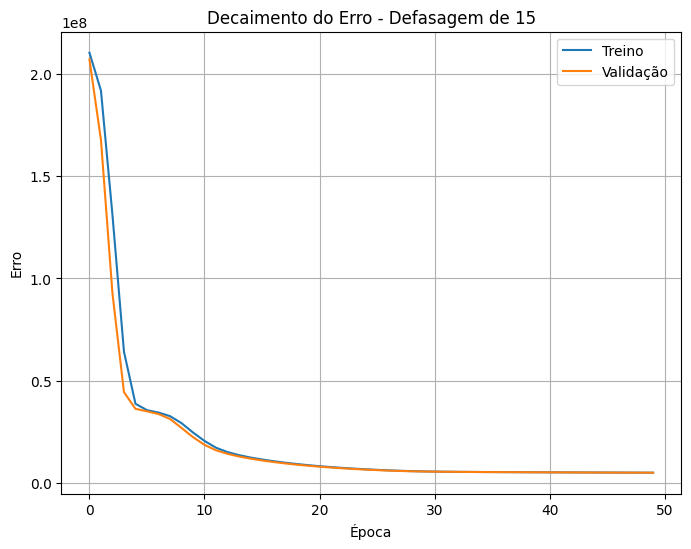

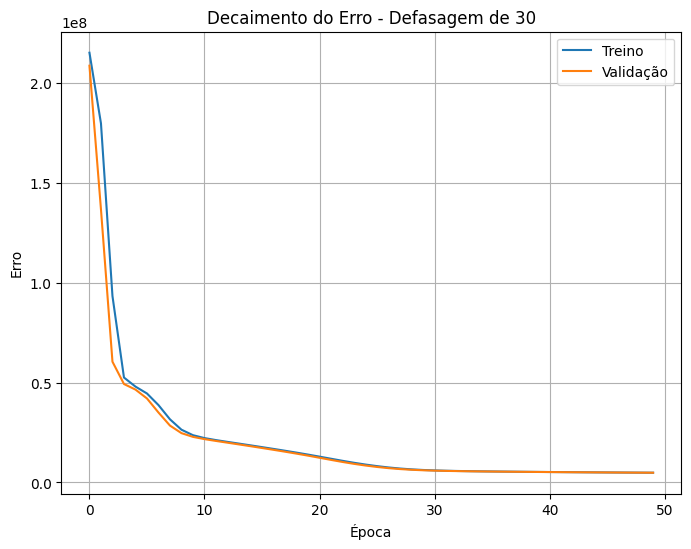

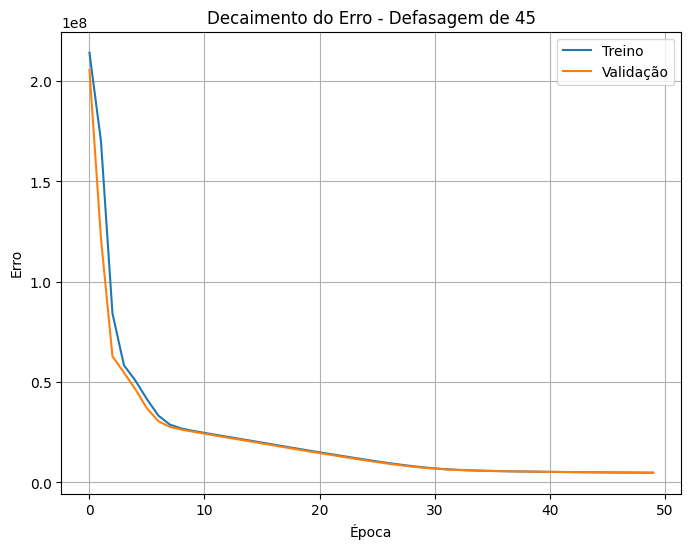


Avaliação no conjunto de teste:

Modelo com defasagem de 15:
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step


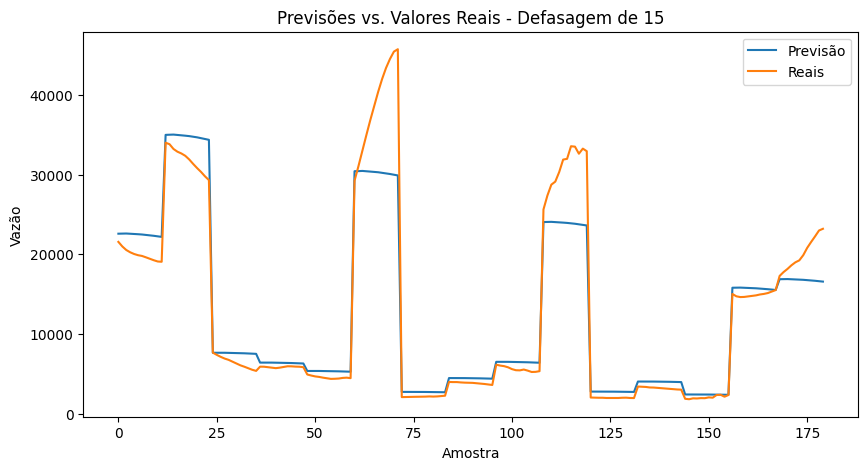

MAPE no conjunto de teste: 0.17868889346079717

Modelo com defasagem de 30:
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step


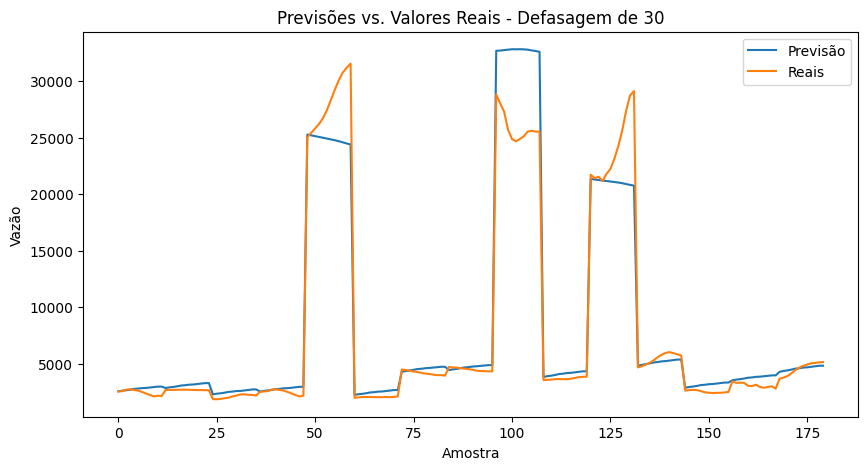

MAPE no conjunto de teste: 0.166772227436802

Modelo com defasagem de 45:
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step


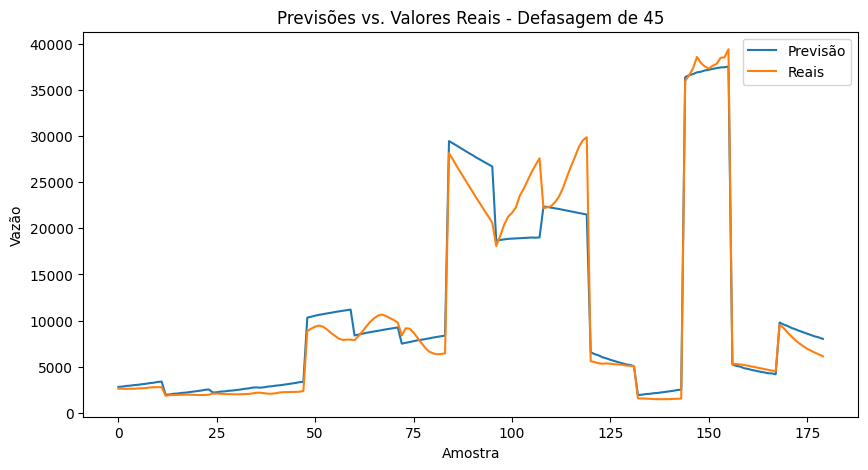

MAPE no conjunto de teste: 0.14257007643591632


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import random

# Definir a seed
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Dividir dados em treino e teste
X_train_15, X_test_15, y_train_15, y_test_15 = train_test_split(X_15, y_15, test_size=0.2, random_state=seed)
X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X_30, y_30, test_size=0.2, random_state=seed)
X_train_45, X_test_45, y_train_45, y_test_45 = train_test_split(X_45, y_45, test_size=0.2, random_state=seed)
# Dividir dados de treino em treino e validação
X_train_15, X_val_15, y_train_15, y_val_15 = train_test_split(X_train_15, y_train_15, test_size=0.25, random_state=seed)
X_train_30, X_val_30, y_train_30, y_val_30 = train_test_split(X_train_30, y_train_30, test_size=0.25, random_state=seed)
X_train_45, X_val_45, y_train_45, y_val_45 = train_test_split(X_train_45, y_train_45, test_size=0.25, random_state=seed)

# Função para construir o modelo MLP
def criar_modelo(input_dim, output_dim):
    model = Sequential()
    model.add(InputLayer(shape=(input_dim,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_dim, activation='linear'))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

def criar_dataframe_e_plotar(previsoes, valores_reais, n=15, title='Previsões vs. Valores Reais'):
    df_comparacao = pd.DataFrame({
        'Previsão': np.array(previsoes[:n]).flatten(),
        'Reais': np.array(valores_reais[:n]).flatten()
    })
    
    # Plotar as previsões e valores reais
    plt.figure(figsize=(10, 5))
    plt.plot(df_comparacao['Previsão'], label='Previsão')
    plt.plot(df_comparacao['Reais'], label='Reais')
    plt.title(title)
    plt.xlabel('Amostra')
    plt.ylabel('Vazão')
    plt.legend()
    plt.show()
    
    return df_comparacao

def treinar_e_avaliar(X_train, y_train, X_val, y_val, input_dim):
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed)  # Definir random_state
    history_list = []
    num_epochs = 50
    avg_train_loss_per_epoch = np.zeros(num_epochs)
    avg_val_loss_per_epoch = np.zeros(num_epochs)
    
    for train_index, val_index in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Normalizar os dados
        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_val_fold = scaler.transform(X_val_fold)
        X_val = scaler.transform(X_val)  # Normalizar dados de validação

        # Construir e treinar o modelo
        model = criar_modelo(input_dim, y_train.shape[1])
        history = model.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=64, verbose=0,
                            validation_data=(X_val_fold, y_val_fold))
        # Acumular o histórico de treinamento e validação
        avg_train_loss_per_epoch += history.history['loss']
        avg_val_loss_per_epoch += history.history['val_loss']       
        history_list.append(history)
            
    # Calcular a média dos erros por época
    avg_train_loss_per_epoch /= kfold.n_splits
    avg_val_loss_per_epoch /= kfold.n_splits
    
    return model, history_list, avg_train_loss_per_epoch, avg_val_loss_per_epoch

# Função para calcular o erro MAPE
def avaliar_modelo(model, X_test, y_test, title):
    # Normalizar os dados de teste
    scaler = StandardScaler()
    X_test = scaler.fit_transform(X_test)

    # Avaliar o modelo
    y_pred = model.predict(X_test)
    
    # Plotar previsões vs valores reais
    criar_dataframe_e_plotar(y_pred, y_test, title=title)
    
    # Calcular MAPE
    test_mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f'MAPE no conjunto de teste: {test_mape}')
    return test_mape

# Função para plotar o decaimento do erro
def plot_avg_history(avg_train_loss, avg_val_loss, title):
    plt.figure(figsize=(8, 6))
    plt.plot(avg_train_loss, label='Treino')
    plt.plot(avg_val_loss, label='Validação')
    plt.title(f'Decaimento do Erro - {title}')
    plt.xlabel('Época')
    plt.ylabel('Erro')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Treinar e avaliar para os diferentes conjuntos de dados
model_15, history_15, avg_train_loss_15, avg_val_loss_15 = treinar_e_avaliar(X_train_15, y_train_15, X_val_15, y_val_15, X_train_15.shape[1])
model_30, history_30, avg_train_loss_30, avg_val_loss_30 = treinar_e_avaliar(X_train_30, y_train_30, X_val_30, y_val_30, X_train_30.shape[1])
model_45, history_45, avg_train_loss_45, avg_val_loss_45 = treinar_e_avaliar(X_train_45, y_train_45, X_val_45, y_val_45, X_train_45.shape[1])

# Plotar gráficos para os diferentes conjuntos de dados
plot_avg_history(avg_train_loss_15, avg_val_loss_15, 'Defasagem de 15')
plot_avg_history(avg_train_loss_30, avg_val_loss_30, 'Defasagem de 30')
plot_avg_history(avg_train_loss_45, avg_val_loss_45, 'Defasagem de 45')

# Avaliar modelos
print("\nAvaliação no conjunto de teste:")

print("\nModelo com defasagem de 15:")
test_mape_15 = avaliar_modelo(model_15, X_test_15, y_test_15, 'Previsões vs. Valores Reais - Defasagem de 15')

print("\nModelo com defasagem de 30:")
test_mape_30 = avaliar_modelo(model_30, X_test_30, y_test_30, 'Previsões vs. Valores Reais - Defasagem de 30')

print("\nModelo com defasagem de 45:")
test_mape_45 = avaliar_modelo(model_45, X_test_45, y_test_45, 'Previsões vs. Valores Reais - Defasagem de 45')



In [6]:
#média do MAPE nos 3 resultados
media_mape = np.mean([test_mape_15, test_mape_30, test_mape_45])
print(f'Média MAPE: {media_mape*100:.2f}%')

Média MAPE: 16.27%


Melhores hiperparâmetros: {'neurons': 32, 'learning_rate': 0.001, 'epochs': 200, 'batch_size': 32}


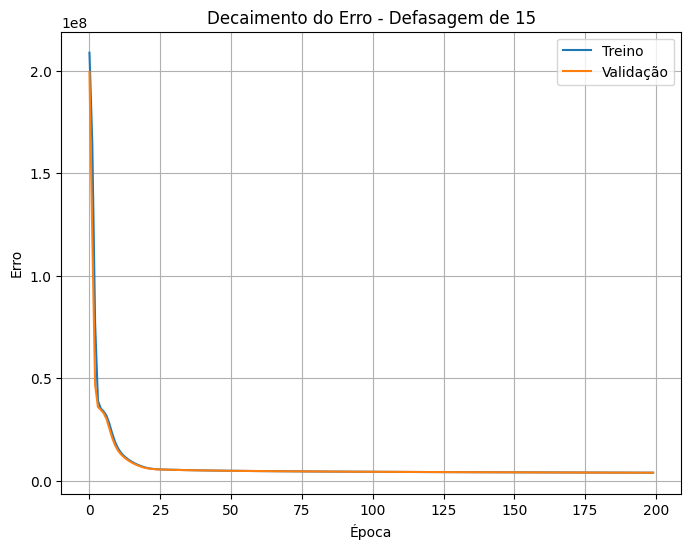

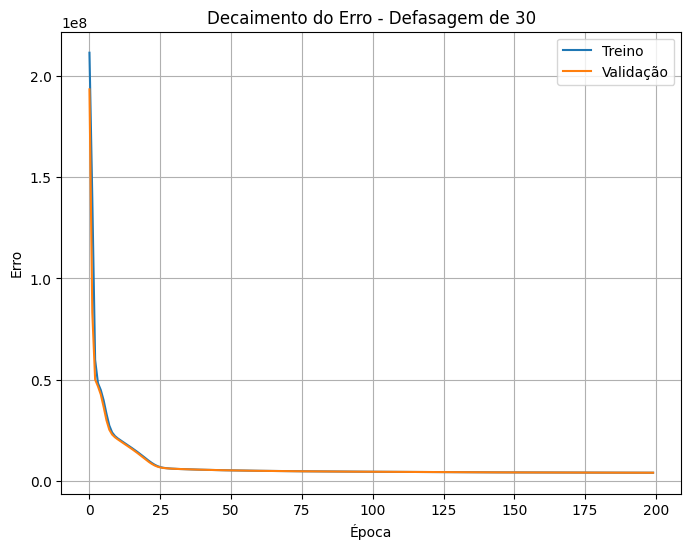

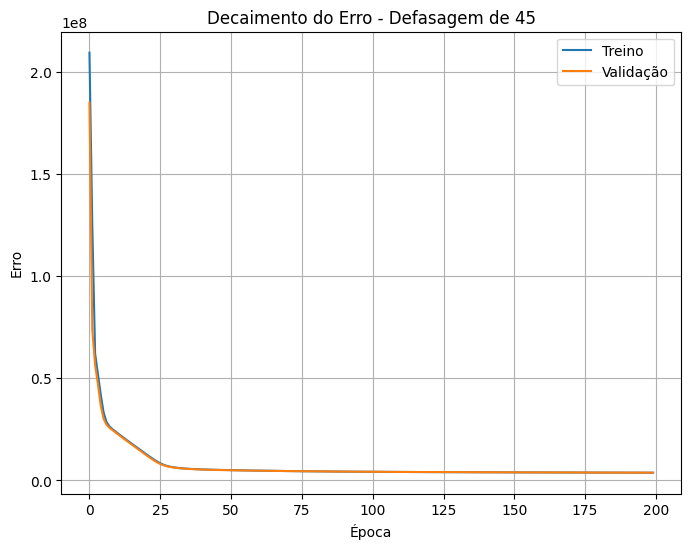


Avaliação no conjunto de teste:

Modelo com defasagem de 15:
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step


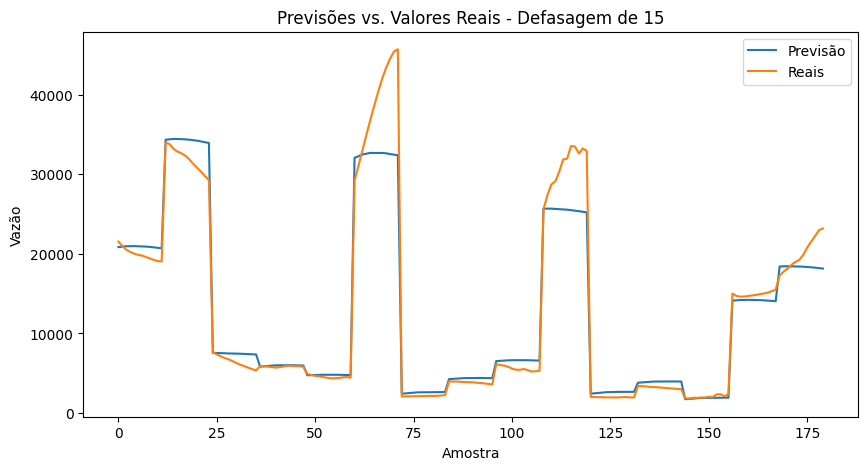

MAPE no conjunto de teste: 0.1520170273017418

Modelo com defasagem de 30:
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


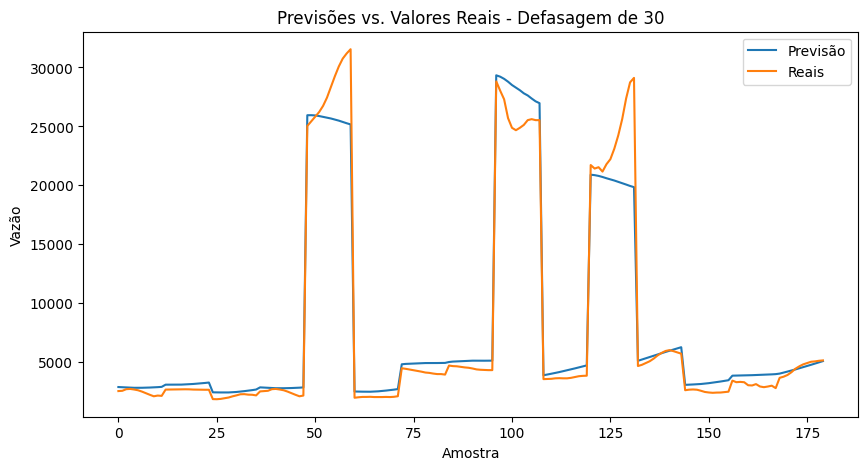

MAPE no conjunto de teste: 0.16045822248068048

Modelo com defasagem de 45:
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step


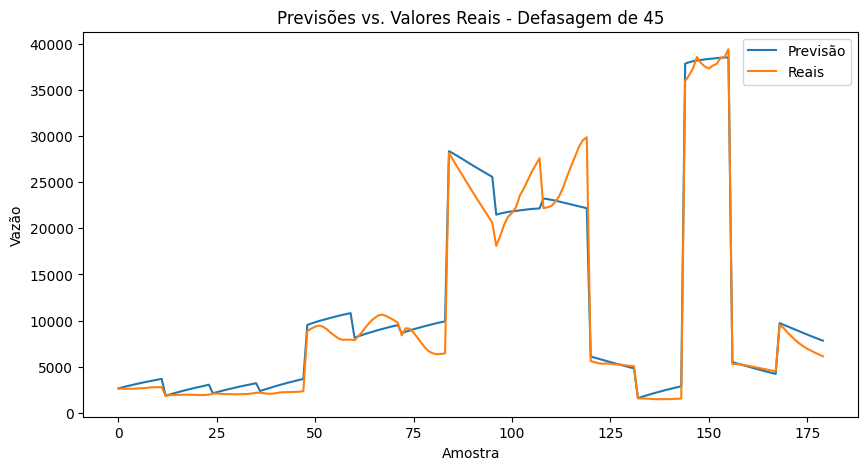

MAPE no conjunto de teste: 0.14835091062651484


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
import tensorflow as tf
import random

# Definir a seed
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Dividir dados em treino e teste
X_train_15, X_test_15, y_train_15, y_test_15 = train_test_split(X_15, y_15, test_size=0.2, random_state=seed)
X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X_30, y_30, test_size=0.2, random_state=seed)
X_train_45, X_test_45, y_train_45, y_test_45 = train_test_split(X_45, y_45, test_size=0.2, random_state=seed)
# Dividir dados de treino em treino e validação
X_train_15, X_val_15, y_train_15, y_val_15 = train_test_split(X_train_15, y_train_15, test_size=0.25, random_state=seed)
X_train_30, X_val_30, y_train_30, y_val_30 = train_test_split(X_train_30, y_train_30, test_size=0.25, random_state=seed)
X_train_45, X_val_45, y_train_45, y_val_45 = train_test_split(X_train_45, y_train_45, test_size=0.25, random_state=seed)

# Função para construir o modelo MLP
def criar_modelo(input_dim, output_dim, neurons=64, learning_rate=0.01):
    model = Sequential()
    model.add(InputLayer(shape=(input_dim,)))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(output_dim, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

def criar_dataframe_e_plotar(previsoes, valores_reais, n=15, title='Previsões vs. Valores Reais'):
    df_comparacao = pd.DataFrame({
        'Previsão': np.array(previsoes[:n]).flatten(),
        'Reais': np.array(valores_reais[:n]).flatten()
    })
    
    # Plotar as previsões e valores reais
    plt.figure(figsize=(10, 5))
    plt.plot(df_comparacao['Previsão'], label='Previsão')
    plt.plot(df_comparacao['Reais'], label='Reais')
    plt.title(title)
    plt.xlabel('Amostra')
    plt.ylabel('Vazão')
    plt.legend()
    plt.show()
    
    return df_comparacao

# Função para treinar e avaliar com KFold
def treinar_e_avaliar(X_train, y_train, X_val, y_val, input_dim, params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
    history_list = []
    num_epochs = params['epochs']
    avg_train_loss_per_epoch = np.zeros(num_epochs)
    avg_val_loss_per_epoch = np.zeros(num_epochs)
    
    
    
    for train_index, val_index in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Normalizar os dados
        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_val_fold = scaler.transform(X_val_fold)
        X_val = scaler.transform(X_val)  # Normalizar dados de validação

        # Construir e treinar o modelo
        model = criar_modelo(input_dim, y_train.shape[1], params['neurons'], params['learning_rate'])
        history = model.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=params['batch_size'], verbose=0,
                            validation_data=(X_val_fold, y_val_fold))
        # Acumular o histórico de treinamento e validação
        avg_train_loss_per_epoch += history.history['loss']
        avg_val_loss_per_epoch += history.history['val_loss']       
        history_list.append(history)
            
    # Calcular a média dos erros por época
    avg_train_loss_per_epoch /= kfold.n_splits
    avg_val_loss_per_epoch /= kfold.n_splits
    
    return model, history_list, avg_train_loss_per_epoch, avg_val_loss_per_epoch

# Função para calcular o erro MAPE
def avaliar_modelo(model, X_test, y_test, title):
    # Normalizar os dados de teste
    scaler = StandardScaler()
    X_test = scaler.fit_transform(X_test)

    # Avaliar o modelo
    y_pred = model.predict(X_test)
    
    # Plotar previsões vs valores reais
    criar_dataframe_e_plotar(y_pred, y_test, title=title)
    
    # Calcular MAPE
    test_mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f'MAPE no conjunto de teste: {test_mape}')
    return test_mape

# Função para plotar o decaimento do erro
def plot_avg_history(avg_train_loss, avg_val_loss, title):
    plt.figure(figsize=(8, 6))
    plt.plot(avg_train_loss, label='Treino')
    plt.plot(avg_val_loss, label='Validação')
    plt.title(f'Decaimento do Erro - {title}')
    plt.xlabel('Época')
    plt.ylabel('Erro')
    plt.legend()
    plt.grid(True)
    plt.show()



# Definir os parâmetros para o RandomizedSearchCV
param_dist = {
    'neurons': [32, 64, 128],
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
    'epochs': [50, 100, 200]
}

# Realizar a busca aleatória para otimizar os hiperparâmetros
input_dim = X_train_15.shape[1]
output_dim = y_train_15.shape[1]

model_cv = KerasRegressor(model=criar_modelo, input_dim=input_dim, output_dim=output_dim, verbose=0,neurons=64, learning_rate=0.01)
random_search = RandomizedSearchCV(estimator=model_cv, param_distributions=param_dist, n_iter=10, cv=3, random_state=seed, n_jobs=-1)
random_search_result = random_search.fit(X_train_15, y_train_15)

# Obter os melhores hiperparâmetros
best_params = random_search_result.best_params_
print(f'Melhores hiperparâmetros: {best_params}')

# Treinar e avaliar para os diferentes conjuntos de dados com os melhores hiperparâmetros
model_15, history_15, avg_train_loss_15, avg_val_loss_15 = treinar_e_avaliar(X_train_15, y_train_15, X_val_15, y_val_15, input_dim, best_params)
model_30, history_30, avg_train_loss_30, avg_val_loss_30 = treinar_e_avaliar(X_train_30, y_train_30, X_val_30, y_val_30, X_train_30.shape[1], best_params)
model_45, history_45, avg_train_loss_45, avg_val_loss_45 = treinar_e_avaliar(X_train_45, y_train_45, X_val_45, y_val_45, X_train_45.shape[1], best_params)

# Plotar gráficos para os diferentes conjuntos de dados
plot_avg_history(avg_train_loss_15, avg_val_loss_15, 'Defasagem de 15')
plot_avg_history(avg_train_loss_30, avg_val_loss_30, 'Defasagem de 30')
plot_avg_history(avg_train_loss_45, avg_val_loss_45, 'Defasagem de 45')

# Avaliar modelos
print("\nAvaliação no conjunto de teste:")

print("\nModelo com defasagem de 15:")
test_mape_15 = avaliar_modelo(model_15, X_test_15, y_test_15, 'Previsões vs. Valores Reais - Defasagem de 15')

print("\nModelo com defasagem de 30:")
test_mape_30 = avaliar_modelo(model_30, X_test_30, y_test_30, 'Previsões vs. Valores Reais - Defasagem de 30')

print("\nModelo com defasagem de 45:")
test_mape_45 = avaliar_modelo(model_45, X_test_45, y_test_45, 'Previsões vs. Valores Reais - Defasagem de 45')
